In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [7]:
[1] + z[1:]

array([1.91390504, 1.61048792, 1.56799627, 1.0346431 , 1.63168737,
       1.94928307, 1.71492146, 1.18820318, 1.59014799])

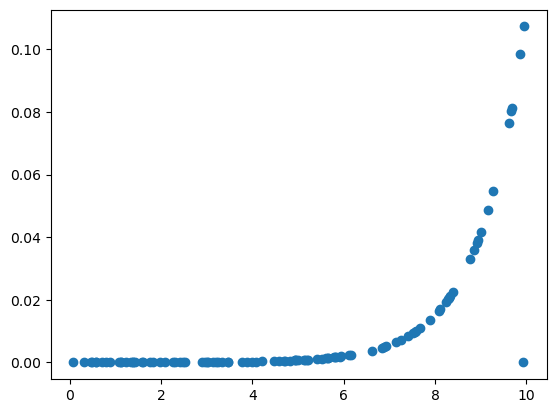

In [25]:
n = 100

alpha = 0
beta = -.546

z = np.random.rand(n) * 10
# z = np.sort(z)

den = 1 + np.exp(z[1:]).sum()

p = np.exp(np.concatenate(([1], z[1:]))) / den

plt.scatter(z, p)

In [26]:
p.sum()

1.0000088010047798

1.0000000000000004

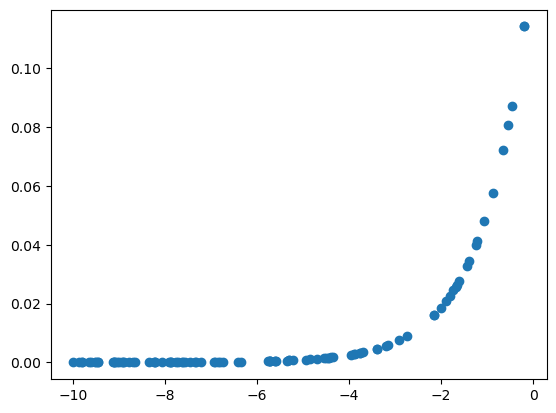

In [39]:
n = 100

alpha = 0
beta = -10

z = alpha  + beta * np.random.rand(n)
# z = np.sort(z)

den = np.exp(z).sum()

p = np.exp(z) / den

plt.scatter(z, p)

p.sum()

1.0

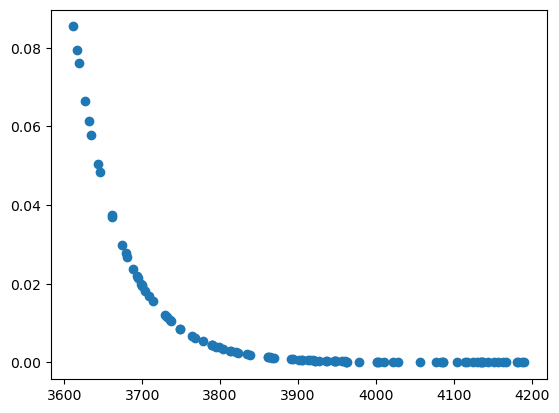

In [45]:
n = 100

alpha = 0
beta = -1 / 60

times = 3600 + np.random.rand(n) * 600

z = alpha  + beta * times
# z = np.sort(z)

den = np.exp(z).sum()

p = np.exp(z) / den

plt.scatter(times, p)

p.sum()

In [33]:
p.sum()

0.9999999999999999

In [50]:
1.27 * .57

0.7239

In [49]:
def tour_length(rho, c, n, a):

    delta = n / a

    l = 2 * rho + .73 * c / np.sqrt(delta)

    return l

rho = 0
c = 8
n = 10
a = 1e6

tour_length(rho, c, n, a)

1846.7701535383335

In [57]:
from scipy.stats import binom

n_chargers = 100
n_stations = 10
p = .5
k = 5

dist = binom(n, p)
dist.ppf(.5)

5.0

In [66]:
import numpy as np

def perm(n, n_p):
    
    p = []
    d = 1
    
    for i in range(n):
        
        if n_p % 2 == 0:
            
            p.append(d)
            d = 1
            
        else:
            
            d += 1
            
        n_p //= 2
        
    return p

def randperm(n):
    
    n_p = np.random.randint(0, 2 ** (n - 1))
    
    return perm(n, n_p)

randperm(10)

[6, 2, 2]

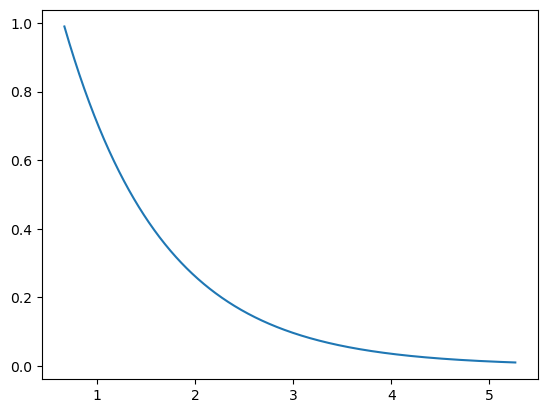

In [136]:
from scipy.stats import binom, expon, poisson, hypergeom, powerlaw, expon

n_chargers = 100
n_stations = 10
p = .5
k = 5

mu = .659

dist = expon(mu)

# x = np.arange(dist.ppf(1e-2), dist.ppf(1 - 1e-2) + 1, 1)
x = np.linspace(dist.ppf(.01), dist.ppf(.99), 1000)

plt.plot(x, dist.pdf(x))

In [85]:
from scipy.stats import binom, expon, poisson, hypergeom

n_chargers = 100
n_station = 5
failure_rate = .05

n_failures = failure_rate * n_chargers

print(n_failures)

dist = hypergeom(n_chargers, n_station,n_failures)

failures_at_station = np.arange(0, n_station + 1, 1)

1 - dist.pmf(0), dist.sf(0)

# plt.plot(failures_at_station, dist.pmf(failures_at_station))

5.0


(0.23041004671159315, 0.2304100467115931)

In [112]:
from scipy.stats import binom, expon, poisson, hypergeom

n_chargers = 100
failure_rate = .5
n_stations = 10

mu = n_chargers / n_stations

station_size_distribution = poisson(mu)

station_sizes = np.arange(0, n_chargers, 1) + 1
station_size_likelihoods = station_size_distribution.pmf(station_sizes)

# plt.plot(station_sizes, station_size_likelihoods)

n_failures = failure_rate * n_chargers

# print(n_failures)

n_failed_stations = 0

for idx, station_size in enumerate(station_sizes):
    # print(station_size, station_size_likelihoods[idx])

    station_failures_distribution = hypergeom(n_chargers, n_station, n_failures)

    expected_stations_at_size = station_size_likelihoods[idx] * n_stations
    nonzero_failure_likelihood = 1 - station_failures_distribution.pmf(0)

    n_failed_stations += (
        nonzero_failure_likelihood * expected_stations_at_size
    )
    # station_failures_distribution = np.arange(0, n_station + 1, 1)
    
    # print(1 - station_failures_distribution.pmf(0), station_failures_distribution.sf(0))
    
    # plt.plot(failures_at_station, dist.pmf(failures_at_station))

print(n_failed_stations)

9.718136305118742


In [182]:
from scipy.stats import binom, expon, poisson, hypergeom

n_chargers = 100
failure_rate = .5
n_stations = 40

station_size_distribution = binom(n_chargers, 1 / n_stations)

station_sizes = np.arange(0, n_chargers, 1) + 1
station_size_likelihoods = station_size_distribution.pmf(station_sizes)

n_failures = failure_rate * n_chargers

n_failed_stations = 0

for idx, station_size in enumerate(station_sizes):

    # station_failures_distribution = hypergeom(n_chargers, n_station, n_failures)

    expected_stations_at_size = station_size_likelihoods[idx] * n_stations

    n = station_size
    k = 0
    N = n_chargers
    K = n_failures

    pnz = 1 - comb(n, k) * comb(N - n, K - k) / comb(N, K)
    
    nonzero_failure_likelihood = pnz

    n_failed_stations += (
        nonzero_failure_likelihood * expected_stations_at_size
    )

print(n_failed_stations)

28.720475906363298


In [184]:
from scipy.stats import binom, hypergeom

def non_zero_failed(n_chargers, failure_rate, n_stations):

    station_size_distribution = binom(n_chargers, 1 / n_stations)

    station_sizes = np.arange(0, n_chargers, 1) + 1
    station_size_likelihoods = station_size_distribution.pmf(station_sizes)
    
    n_failures = failure_rate * n_chargers
    
    n_failed_stations = 0
    
    for idx, station_size in enumerate(station_sizes):
    
        # station_failures_distribution = hypergeom(n_chargers, n_station, n_failures)
    
        expected_stations_at_size = station_size_likelihoods[idx] * n_stations
    
        n = station_size
        k = 0
        N = n_chargers
        K = n_failures
    
        pnz = 1 - comb(n, k) * comb(N - n, K - k) / comb(N, K)
        
        nonzero_failure_likelihood = pnz
    
        n_failed_stations += (
            nonzero_failure_likelihood * expected_stations_at_size
        )

    return n_failed_stations

m = 21 

n_chargers = 100
failure_rate = np.linspace(0, 1, m)
n_stations = np.linspace(0, 100, m)

nzf = np.zeros((m, m))

for idx_r in range(m):
    for idx_c in range(m):

        nzf[idx_r, idx_c] = non_zero_failed(
            n_chargers, failure_rate[idx_r], n_stations[idx_c]
        )

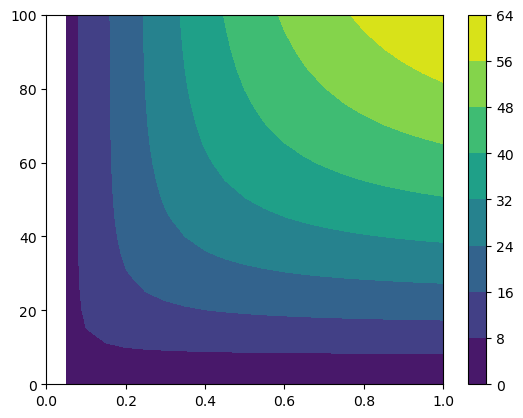

In [191]:
plt.contourf(failure_rate, n_stations, nzf)
plt.colorbar()

In [198]:
def tour_length(rho, c, n, a):

    delta = n / a

    l = 2 * rho + .73 * c / np.sqrt(delta)

    return l

c = nzf
n = 100
a = 1e6
rho = np.sqrt(a) / 2

l_t = tour_length(rho, c, n, a)

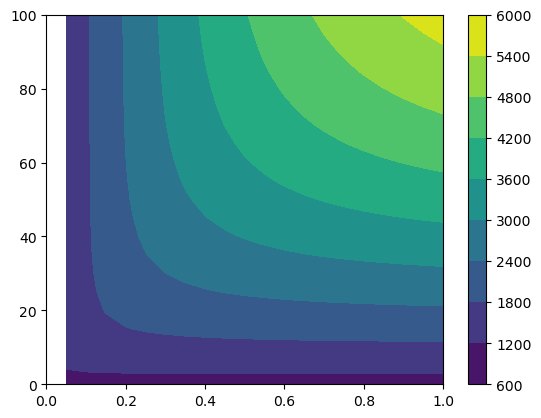

In [199]:
plt.contourf(failure_rate, n_stations, l_t)
plt.colorbar()

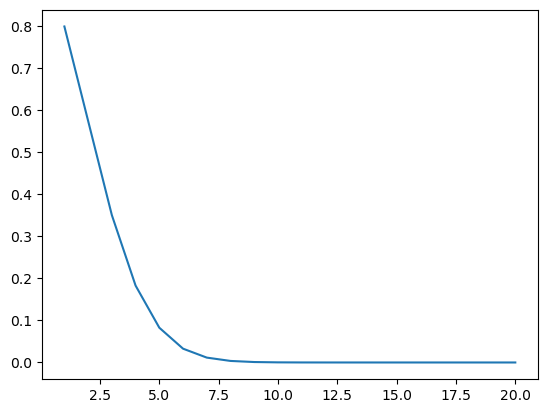

In [178]:
n_chargers = 1029
failure_rate = .005
n_stations = 344

mu = 1 / n_stations
station_size_distribution = binom(n_chargers, mu)

# station_sizes = np.arange(0, n_chargers, 1) + 1
station_sizes = np.arange(0, 20, 1) + 1
station_size_likelihoods = station_size_distribution.sf(station_sizes)

plt.plot(station_sizes, station_size_likelihoods)

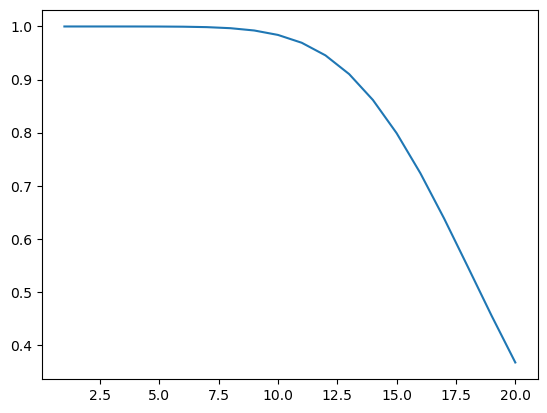

In [179]:
n_chargers = 901
failure_rate = .005
n_stations = 47

mu = 1 / n_stations
station_size_distribution = binom(n_chargers, mu)

# station_sizes = np.arange(0, n_chargers, 1) + 1
station_sizes = np.arange(0, 20, 1) + 1
station_size_likelihoods = station_size_distribution.sf(station_sizes)

plt.plot(station_sizes, station_size_likelihoods)

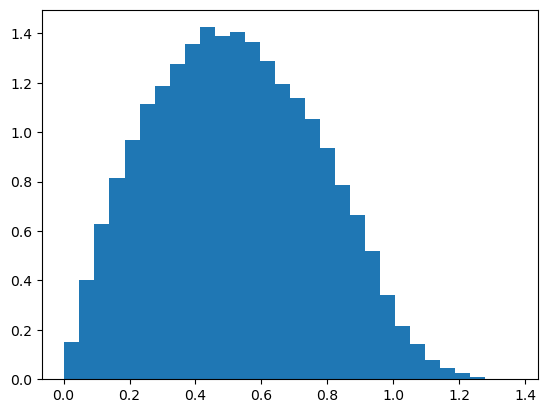

In [227]:
n = 100000

x0 = np.random.rand(n)
y0 = np.random.rand(n)
x1 = np.random.rand(n)
y1 = np.random.rand(n)

d = nice.utilities.pythagorean(x0, y0, x1, y1)

_ = plt.hist(d, density = True, bins = 30)

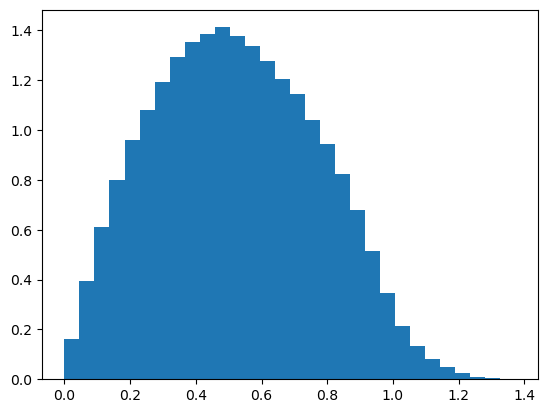

In [237]:
n = 1000

x = np.random.rand(n)
y = np.random.rand(n)

x0, x1 = np.meshgrid(x, x, indexing = 'ij')
y0, y1 = np.meshgrid(y, y, indexing = 'ij')

d = nice.utilities.pythagorean(x0, y0, x1, y1).flatten()

_ = plt.hist(d, density = True, bins = 30)

In [238]:
np.mean(d), np.sqrt(2) / 2, np.pi / 4

(0.5227700116086859, 0.7071067811865476, 0.7853981633974483)

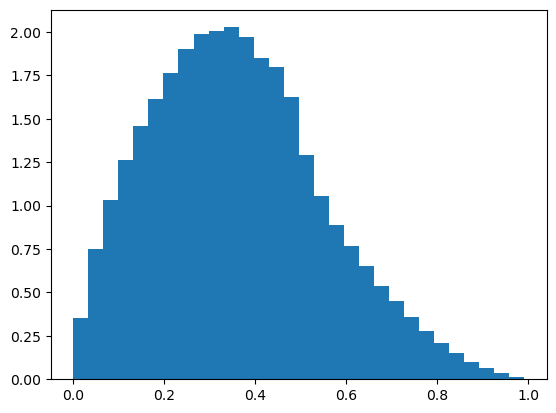

In [245]:
n = 1000

rng = np.random.default_rng()

r = rng.uniform(0, .5, size = n)
theta = rng.uniform(0, 2 * np.pi, size = n)

x = r * np.cos(theta)
y = r * np.sin(theta)

x0, x1 = np.meshgrid(x, x, indexing = 'ij')
y0, y1 = np.meshgrid(y, y, indexing = 'ij')

d = nice.utilities.pythagorean(x0, y0, x1, y1)

_ = plt.hist(d.flatten(), density = True, bins = 30)

In [276]:
means = []

m = 10000

for idx in nice.progress_bar.ProgressBar(range(m)):

    stations = rng.choice(list(range(0, n)), size = 100, replace = False)
    origins = [idx for idx in range(0, n) if idx not in stations]

    d_o = d[origins]
    d_o_s = d_o[:, stations]
    d_m = d_o_s.min(axis = 0)
    
    means.append(d_m.mean())

 [------------------>] 100.00%, 227.45 it/s, 43.97 s elapsed, 0.00 s remaining

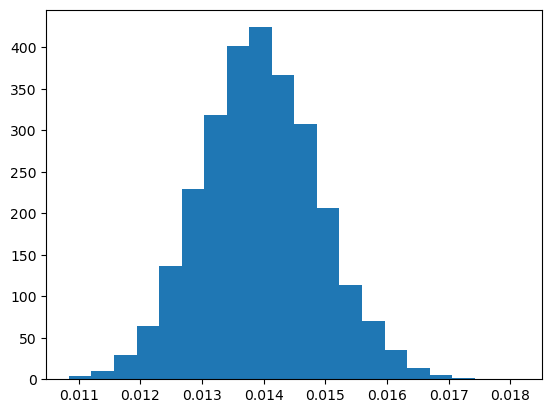

In [277]:
_ = plt.hist(means, density = True, bins = 20)